In [168]:
#from __future__ import print_function

#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mir_eval
import librosa
import librosa.display
from glob import glob
import IPython.display

In [169]:
audio_path = './'

In [199]:
#Set smaple directory and load
data_dir = './breaks01' #set directory for audio files
#audio_files = glob(data_dir + '/*.wav')

audio_files = librosa.util.find_files('./breaks01', recurse=False)

files_loaded = len(audio_files)
print('Files loaded', files_loaded, '\n')

print('List of loaded files')
for counter, value in enumerate(audio_files):
    print(counter, value)


#Select file number
filenumber = int(input('Select file:'))

#Load file number
y, sr = librosa.load(audio_files[filenumber], sr=None)
#time = np.arange(0, len(y)) / sr
#print('Time', time, '\n')
print('Sample rate', sr)

Files loaded 13 

List of loaded files
0 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_01.wav
1 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_02.wav
2 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_03.wav
3 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_04.wav
4 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_05.wav
5 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_06.wav
6 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_07.wav
7 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_08.wav
8 /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/DNB_BREAK_09.wav
9 /Users/rasmusk

File selected: /Users/rasmuskjaerbo/Google Drive/05_SMC/SMC08/SMC08-SemesterProject/Librosa/breaks01/ras_kickdrum_174bpm.wav


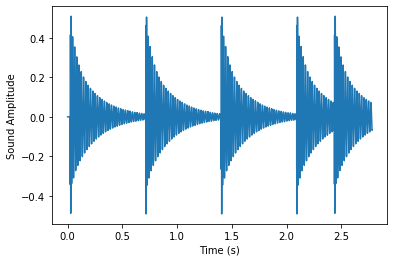

In [200]:
print('File selected:', audio_files[filenumber])

#PAD THE INPUT FILE WITH 200 SAMPLES OF ZEROS

y = np.insert(y, 0, np.zeros(1000), axis=0)

fig, ax = plt.subplots()
time = np.arange(0, len(y)) / sr
ax.plot(time, y)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()
IPython.display.Audio(data=y, rate=sr)

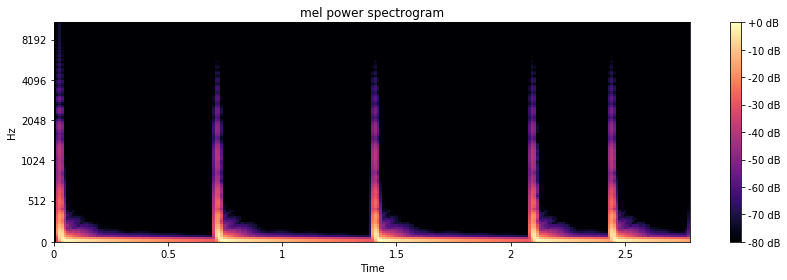

In [201]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [202]:
#Separate into harmonic and percussive part
y_h, y_p = librosa.effects.hpss(y)

print('Percussive content')
IPython.display.Audio(data=y_p, rate=sr)

Percussive content


In [203]:
print('Harmonic content')
IPython.display.Audio(data=y_h, rate=sr)

Harmonic content


Onsets in Beat Frames [  2  61 120 180 210]
Tempo was below 90 ( 87.59 ) and got doubled
New tempo = 175.19 ( 175.1853813559322 )


<Figure size 864x432 with 0 Axes>

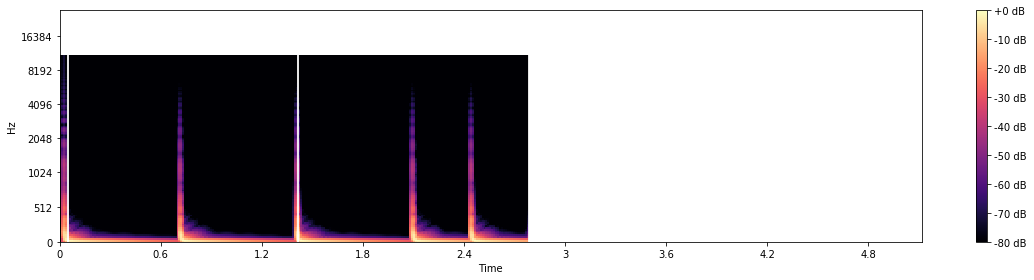

In [205]:
# Now, let's run the beat tracker.

#Select part to process
y = y
hop_length = 512 #Initial value = 512
sr = sr

plt.figure(figsize=(12, 6))

#GENERATE ONSET ENVELOPE
onset_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.max)
#onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median, fmax=sr/4, n_mels=256)

#BEAT TRACK
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, onset_envelope=onset_env, trim=False)

#CALCULATE ONSETS
onsets = librosa.onset.onset_detect(y, sr, onset_envelope=onset_env, hop_length=hop_length, backtrack=True, energy=None, units='frames')
print('Onsets in Beat Frames', onsets)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(16,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(onsets),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.9)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout();

#print('Tempo =', round(tempo, 2), 'BPM')
minTempo = 90
if tempo < minTempo:
    print('Tempo was below', minTempo, '(',round(tempo, 2),')', 'and got doubled')
    tempo = tempo * 2
    print('New tempo =', round(tempo,2), '(', tempo , ')')
else:
    print('Tempo =', tempo)

In [206]:
y_pad = np.insert(y, 0, np.zeros(40), axis=0)
print(y.shape)
print(y_pad.shape)

(122656,)
(122696,)


In [207]:
import pretty_midi

initial_tempo = tempo #Tempo from beat tracker

onset_times = librosa.core.frames_to_time(onsets, sr=sr, hop_length=512, n_fft=None)
print('Onset times', np.round(onset_times, 2))

# Construct a PrettyMIDI object.
pm = pretty_midi.PrettyMIDI(initial_tempo=tempo)
print('Tempo set to: ', round(initial_tempo, 2), '(', initial_tempo, ')')

inst = pretty_midi.Instrument(program=42, is_drum=False, name='Mydrums')
pm.instruments.append(inst)


Onset times [0.02 0.71 1.39 2.09 2.44]
Tempo set to:  175.19 ( 175.1853813559322 )


In [208]:
pitch = 70
velocity = 100
start_time = onset_times
end_time = onset_times + 0.05
#print(end_time)

midinotes = np.column_stack((start_time, end_time))
#print('Notes shape', midinotes.shape)
#print(midinotes)

pitch_array = np.full([onset_times.size, 1], pitch, dtype = int)
velocity_array = np.full([onset_times.size, 1], velocity, dtype = int)


#print(velocity_array)
start_time = start_time.transpose()
midinotes = np.column_stack((midinotes, start_time))
#print(midinotes)

#print(start_time)
end_time = end_time.transpose()
midinotes = np.column_stack((midinotes, start_time))
print('Notes shape', midinotes.shape)

print(midinotes[0:3,:])
#print(midinotes)

#print('P', pitch_array.shape,
#'V', velocity_array.shape,
#'S', start_time.shape,
#'E', end_time.shape)

velocity = 100
pitch = 70

for start_time, end_time in zip(start_time, end_time):
    inst.notes.append(pretty_midi.Note(velocity, pitch, start_time, end_time))
print('Zipped notes', inst.notes[0:5])

#inst.notes.append(pretty_midi.Note(velocity, pitch, start, end))

Notes shape (5, 4)
[[0.02321995 0.07321995 0.02321995 0.02321995]
 [0.70820862 0.75820862 0.70820862 0.70820862]
 [1.39319728 1.44319728 1.39319728 1.39319728]]
Zipped notes [Note(start=0.023220, end=0.073220, pitch=70, velocity=100), Note(start=0.708209, end=0.758209, pitch=70, velocity=100), Note(start=1.393197, end=1.443197, pitch=70, velocity=100), Note(start=2.089796, end=2.139796, pitch=70, velocity=100), Note(start=2.438095, end=2.488095, pitch=70, velocity=100)]


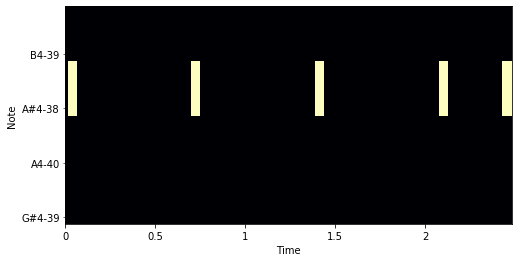

In [209]:
#velocity = 100
#for pitch, start, end in zip([35, 40, 64], [0.2, 0.6, 1.0], [1.1, 1.7, 2.3]):
#    inst.notes.append(pretty_midi.Note(velocity, pitch, start, end))
#print(inst.notes)

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch], hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 68, 72)

fs = sr
IPython.display.Audio(pm.synthesize(fs=sr), rate=sr)

In [210]:
pm.write('./outputs/output_' + str(filenumber) + '_' + str(initial_tempo) + '.mid')

In [ ]:
print('Splash Cymbal has note number {} on drum instruments'.format(
    pretty_midi.drum_name_to_note_number('Splash Cymbal')))

for i in range (35,82):
        print('MIDI#', i, 'is', pretty_midi.note_number_to_drum_name(i))


In [212]:
#beat_times = librosa.frames_to_time(onsets)
y_click = mir_eval.sonify.clicks(onset_times, sr, length=len(y))
y_sum=(y + y_click)
IPython.display.Audio(data=y_sum, rate=sr)

In [ ]:
hop_length = 512
plt.figure(figsize=(8, 4))
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
plt.plot(times, librosa.util.normalize(onset_env), label='Onset strength')
plt.vlines(times[beats], 0, 1.1, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.legend(frameon=True, framealpha=0.75)

# Limit the plot to a 15-second window
#plt.xlim(15, 30)
plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()
plt.show()

In [ ]:
D = librosa.stft(y)

D_harmonic, D_percussive = librosa.decompose.hpss(D)

rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

In [ ]:
#Various onset envelope functions
D = np.abs(librosa.stft(y))
times = librosa.times_like(D)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')

#Mean (mel)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8, label='Mean (mel)')


#Median (custom mel)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median, fmax=8000, n_mels=256)
plt.plot(times, 1 + onset_env / onset_env.max(), alpha=0.8, label='Median (custom mel)')


#Mean (CQT)
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
plt.plot(times, onset_env / onset_env.max(), alpha=0.8, label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()
plt.show()

In [ ]:
# Let's compute separations for a few different margins and compare the results below
D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

plt.figure(figsize=(10, 10))

plt.subplot(5, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.title('Harmonic')
plt.yticks([])
plt.ylabel('margin=1')

plt.subplot(5, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log')
plt.title('Percussive')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic2), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=2')

plt.subplot(5, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive2), ref=rp), y_axis='log')
plt.yticks([]) ,plt.ylabel('')

plt.subplot(5, 2, 5)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic4), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=4')

plt.subplot(5, 2, 6)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive4), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 7)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic8), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=8')

plt.subplot(5, 2, 8)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive8), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 9)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=16')

plt.subplot(5, 2, 10)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
#N-components
n_components = 16

# Separate the magnitude and phase
S, phase = librosa.magphase(D)

# Decompose by nmf
components, activations = librosa.decompose.decompose(S, n_components=n_components, sort=True)

# Play back the reconstruction
# Reconstruct a spectrogram by the outer product of component k and its activation
D_k = components.dot(activations)

# invert the stft after putting the phase back in
y_k = librosa.istft(D_k * phase)

# Visualize the components and activations, just for fun

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(components), ref=np.max), y_axis='log')
plt.xlabel('Component')
plt.ylabel('Frequency')
plt.title('Components')

plt.subplot(1,2,2)
librosa.display.specshow(activations, x_axis='time')
plt.xlabel('Time')
plt.ylabel('Component')
plt.title('Activations')

plt.tight_layout()

# And playback
print('Reconstruction with ' + str(n_components) + ' components')
IPython.display.Audio(data=y_k, rate=sr)